In [1]:
import pandas as pd
import os


In [8]:
# Define the path to the 'free' subfolder
free_folder_path = "../results/free"

# Recursively list all csv files in the 'free' folder
csv_files = []
for root, dirs, files in os.walk(free_folder_path):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

# Split the csv files into annotated and non-annotated lists
annotated_files = [file for file in csv_files if "_annotated" in file]
non_annotated_files = [file for file in csv_files if "_annotated" not in file]

# Concatenate all annotated csv files into a single dataframe
df_annotated = pd.concat([pd.read_csv(file) for file in annotated_files], ignore_index=True)

# Return the first few rows of the concatenated dataframe and the number of non-annotated files
df_annotated.head(), len(non_annotated_files)

(                 model_name  temperature phenomenon decoding_scheme question  \
 0  meta-llama/Llama-2-7b-hf          0.9      irony          greedy      NaN   
 1  meta-llama/Llama-2-7b-hf          0.9      irony          greedy      NaN   
 2  meta-llama/Llama-2-7b-hf          0.9      irony          greedy      NaN   
 3  meta-llama/Llama-2-7b-hf          0.9      irony          greedy      NaN   
 4  meta-llama/Llama-2-7b-hf          0.9      irony          greedy      NaN   
 
    seed  item_id                                             prompt  \
 0     3        1  You will read a short story that describes an ...   
 1     3        2  You will read a short story that describes an ...   
 2     3        3  You will read a short story that describes an ...   
 3     3        4  You will read a short story that describes an ...   
 4     3        5  You will read a short story that describes an ...   
 
                                             response response_option  ...  \


In [16]:
# Check for NA values in the 'response_option' column

def compute_na_percentage(df, column_name):
    """
    Compute the count and percentage of NA values for a specified column in the DataFrame.

    Parameters:
    - df: DataFrame
    - column_name: Name of the column for which to compute the NA values.

    Returns:
    - Tuple containing the count and percentage of NA values.
    """
    na_count = df[column_name].isna().sum()
    na_percentage = (na_count / len(df)) * 100
    return f"There are {na_count} NA values in the '{column_name}' column, which is {na_percentage:.2f}% of the total entries."

# Check for NA values in the 'response_option' column before dropping the rows with NA values
print(compute_na_percentage(df_annotated, 'response_option'))



There are 201 NA values in the 'response_option' column, which is 5.40% of the total entries.


In [20]:
# Drop the rows with NA values in the 'response_option' column
df_annotated.loc[df_annotated['response_option'].isna(), 'response_option'] = df_annotated['annotation_tsvilodub']

df_annotated.loc[df_annotated['response_option'].isna(), 'response_option'] = df_annotated['annotation_wang']

# Check for NA values in the 'response_option' column after dropping the rows with NA values
print(compute_na_percentage(df_annotated, 'response_option'))

There are 1 NA values in the 'response_option' column, which is 0.03% of the total entries.


In [24]:
# Extract rows where 'response_option' is NA
na_response_option_rows = df_annotated[df_annotated['response_option'].isna()]

print('Display the rows with NA values in response_option')
print(na_response_option_rows)

# Drop rows with NA values in the 'response_option' column
df_annotated = df_annotated.dropna(subset=['response_option'])

# Confirm the operation by checking the NA percentage for 'response_option' column after dropping
compute_na_percentage(df_annotated, 'response_option')



Display the rows with NA values in response_option
Empty DataFrame
Columns: [model_name, temperature, phenomenon, decoding_scheme, question, seed, item_id, prompt, response, response_option, target, correct_option, competitor, distractor_associate, distractor_nonsequitur, incorrect_literal, incorrect_nonliteral, incorrect_associate, distractor_lexical_overlap, distractor_associative, distractor_plausibleliteral, distractor_literal, distractor_nonsequitut, incorrect_straightforward, associative_nonsequitur, funny_nonsequitur, neutral_nonsequitur, incorrect_lexical_overlap, incorrect_social_convention, annotation_tsvilodub, annotation_wang]
Index: []

[0 rows x 31 columns]


"There are 0 NA values in the 'response_option' column, which is 0.00% of the total entries."

In [25]:
# Check the number of unique values in the 'response_option' column
unique_response_options = df_annotated['response_option'].unique()

# Convert the 'response_option' column to a categorical (factor) type
df_annotated['response_option'] = df_annotated['response_option'].astype('category')

len(unique_response_options), unique_response_options


(19,
 array(['error', 'target', 'competitor', 'distractor_associate',
        'distractor_associative', 'distractor_literal',
        'distractor_plausibleliteral', 'incorrect_associate',
        'incorrect_nonliteral', 'incorrect_social_convention',
        'incorrect_lexical_overlap', 'distractor_nonsequitur',
        'incorrect_literal', 'distractor_lexical_overlap',
        'neutral_nonsequitur', 'incorrect_straightforward',
        'funny_nonsequitur', 'distractor_nonsequitut',
        'associative_nonsequitur'], dtype=object))

In [26]:
# Replace the specified values in the 'response_option' column
df_annotated['response_option'] = df_annotated['response_option'].replace({
    'distractor_nonsequitut': 'distractor_nonsequitur',
    'distractor_associate': 'distractor_associative'
})

# Verify the replacement by checking the unique values again
unique_response_options_after_replacement = df_annotated['response_option'].unique()
unique_response_options_after_replacement


['error', 'target', 'competitor', 'distractor_associative', 'distractor_literal', ..., 'distractor_lexical_overlap', 'neutral_nonsequitur', 'incorrect_straightforward', 'funny_nonsequitur', 'associative_nonsequitur']
Length: 17
Categories (17, object): ['associative_nonsequitur', 'competitor', 'distractor_associative', 'distractor_lexical_overlap', ..., 'incorrect_social_convention', 'incorrect_straightforward', 'neutral_nonsequitur', 'target']

In [29]:
# Group by 'phenomenon' and 'response_option' to check the unique association of responses with phenomena
association_counts = df_annotated.groupby(['phenomenon', 'response_option']).size().reset_index(name='count')

association_counts.pivot(index='phenomenon', columns='response_option', values='count').fillna(0)

# Compute the total counts per phenomenon
total_counts_by_phenomenon = association_counts.groupby('phenomenon')['count'].sum()

# Normalize the counts of responses by phenomena
association_counts['normalized_count'] = association_counts.apply(
    lambda row: row['count'] / total_counts_by_phenomenon[row['phenomenon']], axis=1)

# Pivot the DataFrame to display normalized counts
normalized_counts_pivot = association_counts.pivot(index='phenomenon', columns='response_option', values='normalized_count').fillna(0)
normalized_counts_pivot


/var/folders/jc/6ctllcx143xbrgx01x69skg80000gn/T/ipykernel_25918/1105708177.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  association_counts = df_annotated.groupby(['phenomenon', 'response_option']).size().reset_index(name='count')


response_option,associative_nonsequitur,competitor,distractor_associative,distractor_lexical_overlap,distractor_literal,distractor_nonsequitur,distractor_plausibleliteral,error,funny_nonsequitur,incorrect_associate,incorrect_lexical_overlap,incorrect_literal,incorrect_nonliteral,incorrect_social_convention,incorrect_straightforward,neutral_nonsequitur,target
phenomenon,,,,,,,,,,,,,,,,,
coherence,0.000000,0.210227,0.000000,0.000000,0.000000,0.000000,0.000000,0.217045,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.572727
deceits,0.000000,0.023810,0.000000,0.000000,0.000000,0.000000,0.000000,0.211905,0.000000,0.000000,0.033333,0.178571,0.000000,0.030952,0.000000,0.000000,0.521429
humour,0.108014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.423345,0.097561,0.000000,0.000000,0.000000,0.000000,0.000000,0.148084,0.054007,0.168990
indirect_speech,0.000000,0.143182,0.043182,0.043182,0.000000,0.000000,0.000000,0.222727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.547727
irony,0.000000,0.307273,0.081818,0.000000,0.000000,0.001818,0.000000,0.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.389091
maxims,0.000000,0.119617,0.000000,0.000000,0.000000,0.000000,0.000000,0.186603,0.000000,0.126794,0.000000,0.050239,0.184211,0.000000,0.000000,0.000000,0.332536
metaphor,0.000000,0.006818,0.000000,0.000000,0.038636,0.027273,0.102273,0.202273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.622727


In [31]:
# Group by 'phenomenon', 'model_name', and 'response_option', then compute the counts
association_counts_model_phenomenon = df_annotated.groupby(['phenomenon', 'model_name', 'response_option']).size().reset_index(name='count')

# Compute the total count for each combination of 'phenomenon' and 'model_name'
total_counts_model_phenomenon = df_annotated.groupby(['phenomenon', 'model_name']).size().reset_index(name='total_count')

# Merge the dataframes on 'phenomenon' and 'model_name'
normalized_counts = pd.merge(association_counts_model_phenomenon, total_counts_model_phenomenon, on=['phenomenon', 'model_name'])

# Compute the normalized count
normalized_counts['normalized_count'] = normalized_counts['count'] / normalized_counts['total_count']

# Pivot the table for better visualization
normalized_counts_pivot = normalized_counts.pivot_table(index=['phenomenon', 'model_name'], columns='response_option', values='normalized_count').fillna(0)

normalized_counts_pivot  # Displaying the first 10 rows for brevity


/var/folders/jc/6ctllcx143xbrgx01x69skg80000gn/T/ipykernel_25918/1693471540.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  association_counts_model_phenomenon = df_annotated.groupby(['phenomenon', 'model_name', 'response_option']).size().reset_index(name='count')


response_option                           associative_nonsequitur  competitor  \
phenomenon      model_name                                                      
coherence       google/flan-t5-xl                        0.000000    0.200000   
                gpt-3.5-turbo-instruct                   0.000000    0.227778   
                meta-llama/Llama-2-7b-hf                 0.000000    0.196875   
deceits         google/flan-t5-xl                        0.000000    0.000000   
                gpt-3.5-turbo-instruct                   0.000000    0.025000   
                meta-llama/Llama-2-7b-hf                 0.000000    0.041667   
humour          google/flan-t5-xl                        0.040000    0.000000   
                gpt-3.5-turbo-instruct                   0.212851    0.000000   
                meta-llama/Llama-2-7b-hf                 0.020000    0.000000   
indirect_speech google/flan-t5-xl                        0.000000    0.150000   
                gpt-3.5-turbo-instruct                   0.000000    0.140000   
                meta-llama/Llama-2-7b-hf                 0.000000    0.142857   
irony           google/flan-t5-xl                        0.000000    0.720000   
                gpt-3.5-turbo-instruct                   0.000000    0.220000   
                meta-llama/Llama-2-7b-hf                 0.000000    0.137143   
maxims          google/flan-t5-xl                        0.000000    0.000000   
                gpt-3.5-turbo-instruct                   0.000000    0.168421   
                meta-llama/Llama-2-7b-hf                 0.000000    0.135338   
metaphor        google/flan-t5-xl                        0.000000    0.000000   
                gpt-3.5-turbo-instruct                   0.000000    0.000000   
                meta-llama/Llama-2-7b-hf                 0.000000    0.021429   

response_option                           distractor_associative  \
phenomenon      model_name                                         
coherence       google/flan-t5-xl                       0.000000   
                gpt-3.5-turbo-instruct                  0.000000   
                meta-llama/Llama-2-7b-hf                0.000000   
deceits         google/flan-t5-xl                       0.000000   
                gpt-3.5-turbo-instruct                  0.000000   
                meta-llama/Llama-2-7b-hf                0.000000   
humour          google/flan-t5-xl                       0.000000   
                gpt-3.5-turbo-instruct                  0.000000   
                meta-llama/Llama-2-7b-hf                0.000000   
indirect_speech google/flan-t5-xl                       0.100000   
                gpt-3.5-turbo-instruct                  0.005000   
                meta-llama/Llama-2-7b-hf                0.057143   
irony           google/flan-t5-xl                       0.200000   
                gpt-3.5-turbo-instruct                  0.044000   
                meta-llama/Llama-2-7b-hf                0.051429   
maxims          google/flan-t5-xl                       0.000000   
                gpt-3.5-turbo-instruct                  0.000000   
                meta-llama/Llama-2-7b-hf                0.000000   
metaphor        google/flan-t5-xl                       0.000000   
                gpt-3.5-turbo-instruct                  0.000000   
                meta-llama/Llama-2-7b-hf                0.000000   

response_option                           distractor_lexical_overlap  \
phenomenon      model_name                                             
coherence       google/flan-t5-xl                           0.000000   
                gpt-3.5-turbo-instruct                      0.000000   
                meta-llama/Llama-2-7b-hf                    0.000000   
deceits         google/flan-t5-xl                           0.000000   
                gpt-3.5-turbo-instruct                      0.000000   
                meta-llama/Llama-2-7b-hf                    0.00000

/var/folders/jc/6ctllcx143xbrgx01x69skg80000gn/T/ipykernel_25918/247815521.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset_data, x='response_option', y='normalized_count', ax=ax, palette=palette)
/var/folders/jc/6ctllcx143xbrgx01x69skg80000gn/T/ipykernel_25918/247815521.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset_data, x='response_option', y='normalized_count', ax=ax, palette=palette)
/var/folders/jc/6ctllcx143xbrgx01x69skg80000gn/T/ipykernel_25918/247815521.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.b

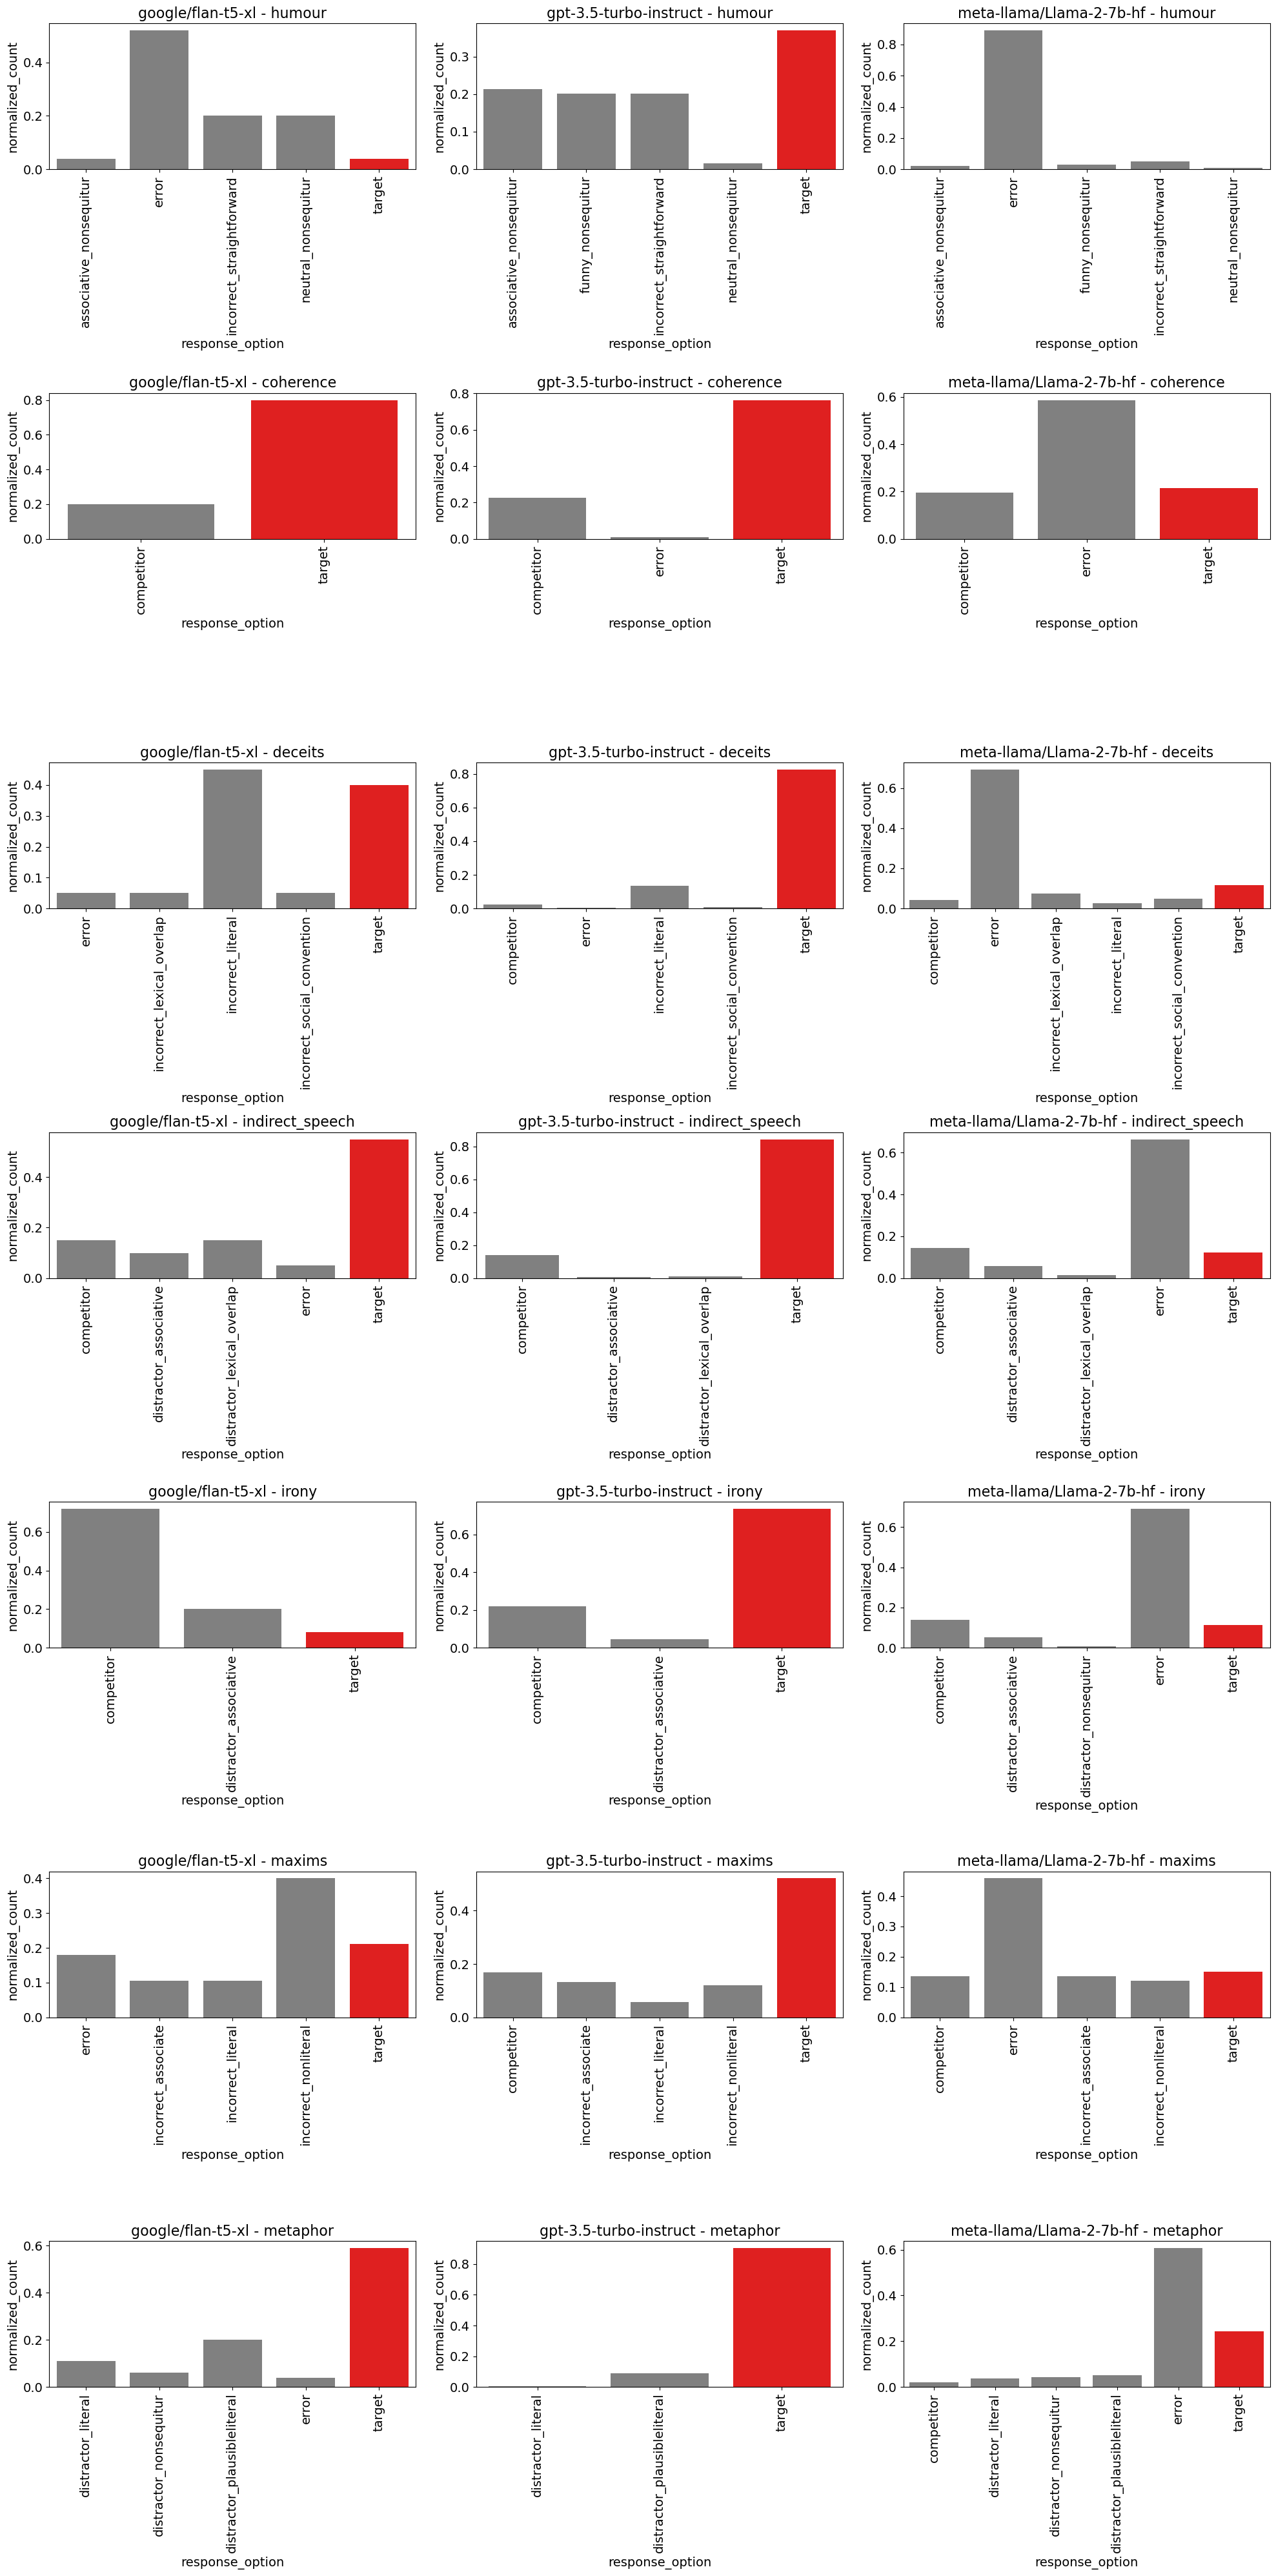

In [44]:
# Reset index for the pivot table for plotting
normalized_counts_pivot_reset = normalized_counts_pivot.reset_index()

# Melt the DataFrame to have 'response_option' and 'normalized_count' as separate columns
melted_data = normalized_counts_pivot_reset.melt(id_vars=['phenomenon', 'model_name'], 
                                                 value_vars=normalized_counts_pivot.columns, 
                                                 var_name='response_option', 
                                                 value_name='normalized_count')

# Filter out rows where normalized_count is zero to only plot non-zero responses
non_zero_melted_data = melted_data[melted_data['normalized_count'] > 0]

# Plot with only non-zero response types on the X-axis for each subplot
import matplotlib.pyplot as plt
import seaborn as sns


## Extract unique models and phenomena
unique_models = non_zero_melted_data['model_name'].unique()
unique_phenomena = non_zero_melted_data['phenomenon'].unique()

# Use a custom color palette to highlight 'target' response_option
palette = {response: 'gray' if response != 'target' else 'red' for response in non_zero_melted_data['response_option'].unique()}

# Set up the grid layout for the subplots
fig, axes = plt.subplots(len(unique_phenomena), len(unique_models), figsize=(20, 40), sharey=False)

# Iterate over each model and phenomenon to create individual subplots
for i, phenomenon in enumerate(unique_phenomena):
    for j, model in enumerate(unique_models):
        ax = axes[i, j]
        subset_data = non_zero_melted_data[(non_zero_melted_data['model_name'] == model) & 
                                           (non_zero_melted_data['phenomenon'] == phenomenon)]
        sns.barplot(data=subset_data, x='response_option', y='normalized_count', ax=ax, palette=palette)
        ax.set_title(f"{model} - {phenomenon}")
        ax.tick_params(axis="x", rotation=90)

        # Set title with larger font size
        ax.set_title(f"{model} - {phenomenon}", fontsize=16)
        
        # Increase tick label size
        ax.tick_params(axis="x", rotation=90, labelsize=14)
        ax.tick_params(axis="y", labelsize=14)
        
        # Increase axis label size
        ax.set_xlabel(ax.get_xlabel(), fontsize=14)
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)

plt.tight_layout()
plt.show()



In [46]:
# Define the path to save the plot as PDF
save_path = "plots/free_response_distribution_by_model_phenomenon.pdf"

# Ensure the directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the plot to the specified path
fig.savefig(save_path, bbox_inches='tight')

save_path


'plots/free_response_distribution_by_model_phenomenon.pdf'